# Face Recognition - Fine Tuning (GOOGLE COLAB)

In [1]:
!nvidia-smi

Thu Jun  4 15:03:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%tensorflow_version 2.x

In [3]:
!pip install -q keras==2.3.0

     |████████████████████████████████| 378kB 3.4MB/s 


In [4]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.3.0


In [0]:
from keras.preprocessing import image as kimage
from keras.applications import resnet_v2
from keras.models import Model
from keras.layers import Dense
from keras.layers import BatchNormalization

# (Mount Google Drive from the menu on the left)

### If you want to test with your pictures: execute this (pictures2 is the folder with your pictures split in train/val/test folders, change it as needed):

In [0]:
my_pictures_dir ="/content/drive/My Drive/2D/pictures_neutral_split"

### If you want to test the code with the celebrities dataset, execute this (thumbnails_features_deduped_sample.zip is the zip file from the url in the slides with the project description):

In [0]:
# !unzip -qq "/content/drive/My Drive/2D/thumbnails_features_deduped_sample.zip"

In [0]:
# !mkdir celebrities

In [0]:
# !mv thumbnails_features_deduped_sample/* celebrities

In [0]:
# import sys
# sys.path.insert(1, '/content/drive/My Drive/2D/')

In [0]:
# import utils_2d

In [0]:
# Not enough pictures now, I will use the sample set from the Project slides
# root_dir = 'celebrities/'
# dest_dir = 'celebrities2/' # or the same as root_dir
# utils_2d.pictures_train_test_val_split(root_dir, dest_dir

In [0]:
# my_pictures_dir = dest_dir

# Define Train/test/val sets

In [0]:
train_dir = my_pictures_dir+"/train"
val_dir = my_pictures_dir+"/val"
test_dir = my_pictures_dir+"/test"

In [18]:
!ls "$my_pictures_dir/test"

alinda	cami  gian  mamma  papi  umbe


# Resnet V2

In [0]:
processing = kimage.ImageDataGenerator(preprocessing_function=resnet_v2.preprocess_input)

In [20]:
train_generator = processing.flow_from_directory(train_dir,
                                                 target_size=(224, 224),
                                                 color_mode="rgb",
                                                 batch_size=32,
                                                 class_mode="categorical",
                                                 shuffle=True,
                                                 seed=1)

Found 848 images belonging to 6 classes.


In [0]:
n_classes = (train_generator.num_classes)

In [22]:
val_generator = processing.flow_from_directory(val_dir,
                                                target_size=(224, 224),
                                                color_mode="rgb",
                                                batch_size=32,
                                                class_mode="categorical",
                                                shuffle=False,
                                                seed=1)


Found 242 images belonging to 6 classes.


In [23]:
test_generator = processing.flow_from_directory(test_dir,
                                                target_size=(224, 224),
                                                color_mode="rgb",
                                                batch_size=32,
                                                class_mode="categorical",
                                                shuffle=False,
                                                seed=1)


Found 124 images belonging to 6 classes.


### See preprocessed images

In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [0]:
batch = np.array(train_generator[0][0])

In [26]:
batch.shape

(32, 224, 224, 3)

In [0]:
pic = batch[20]
plt.imshow(pic)
plt.show()

### Net

In [49]:
base_net = resnet_v2.ResNet152V2(input_shape=(224, 224, 3),
                         weights='imagenet',
                         include_top=False,
                         pooling='avg')

234553344/234545216 [==============================] - 3s 0us/step


In [0]:
for layer in base_net.layers:
  layer.trainable = False # congeliamo i layer della rete resnet_v2 di base, vogliamo solo cambiare i pesi dei layer che aggiungeremo

In [0]:
x = base_net.output
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
pred = Dense(n_classes, activation='softmax')(x)
net = Model(inputs=base_net.input, outputs=pred)

In [0]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=["accuracy"])

In [0]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)

In [56]:
history = net.fit_generator(train_generator,
                  verbose=1,
                  epochs=100,
                  callbacks=[callback],
                  validation_data=val_generator)

Epoch 1/100
 2/27 [=>............................] - ETA: 10:23 - loss: 1.3035 - accuracy: 0.5625

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 19 could not be retrieved. It could be because a worker has died.
  UserWarning)


 3/27 [==>...........................] - ETA: 13:05 - loss: 0.8692 - accuracy: 0.7083

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 11 could not be retrieved. It could be because a worker has died.
  UserWarning)


27/27 [==============================] - 646s 24s/step - loss: 0.1139 - accuracy: 0.9623 - val_loss: 3.4924 - val_accuracy: 0.3802
Epoch 2/100
27/27 [==============================] - 25s 923ms/step - loss: 0.0095 - accuracy: 0.9965 - val_loss: 5.5185 - val_accuracy: 0.4876
Epoch 3/100
27/27 [==============================] - 25s 922ms/step - loss: 0.0016 - accuracy: 0.9988 - val_loss: 5.8662 - val_accuracy: 0.4587
Epoch 4/100
27/27 [==============================] - 25s 920ms/step - loss: 2.1033e-05 - accuracy: 1.0000 - val_loss: 6.5608 - val_accuracy: 0.5331
Epoch 5/100
27/27 [==============================] - 25s 921ms/step - loss: 1.8008e-05 - accuracy: 1.0000 - val_loss: 7.4557 - val_accuracy: 0.4628
Epoch 6/100
27/27 [==============================] - 25s 920ms/step - loss: 8.4735e-05 - accuracy: 1.0000 - val_loss: 6.9051 - val_accuracy: 0.4256
Epoch 7/100
27/27 [==============================] - 25s 920ms/step - loss: 6.7583e-05 - accuracy: 1.0000 - val_loss: 1.8709 - val_accura

## Evaluation


In [0]:
import numpy as np
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report

In [58]:
net.evaluate_generator(train_generator)

[3.4268200397491455, 0.28891509771347046]

In [59]:
net.evaluate_generator(val_generator)

[1.8708909749984741, 0.28099173307418823]

In [60]:
net.evaluate_generator(test_generator)

[1.5349286794662476, 0.25806450843811035]

In [0]:
def classification_report_generator(generator):
  # should not be applied to generators with shuffle = True
  preds = net.predict_generator(generator)
  preds = np.argmax(preds, axis=1)
  real = generator.classes
  ind_dict = generator.class_indices
  num_to_label = [i[0] for i in ind_dict.items()]
  cmat = cm(real, preds)
  cr = classification_report(real, preds, target_names=num_to_label)
  return cmat, cr

In [62]:
cm_val, cr_val = classification_report_generator(val_generator)
print(cr_val)

              precision    recall  f1-score   support

      alinda       0.00      0.00      0.00        36
        cami       1.00      0.02      0.05        41
        gian       1.00      0.02      0.05        43
       mamma       0.24      1.00      0.39        41
        papi       1.00      0.61      0.76        41
        umbe       0.00      0.00      0.00        40

    accuracy                           0.28       242
   macro avg       0.54      0.28      0.21       242
weighted avg       0.56      0.28      0.21       242



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
cm_test, cr_test = classification_report_generator(test_generator)
print(cr_test)

              precision    recall  f1-score   support

      alinda       0.00      0.00      0.00        18
        cami       0.00      0.00      0.00        21
        gian       0.00      0.00      0.00        22
       mamma       0.24      1.00      0.39        21
        papi       1.00      0.48      0.65        21
        umbe       0.04      0.05      0.04        21

    accuracy                           0.26       124
   macro avg       0.21      0.25      0.18       124
weighted avg       0.22      0.26      0.18       124



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
import matplotlib.pyplot as plt

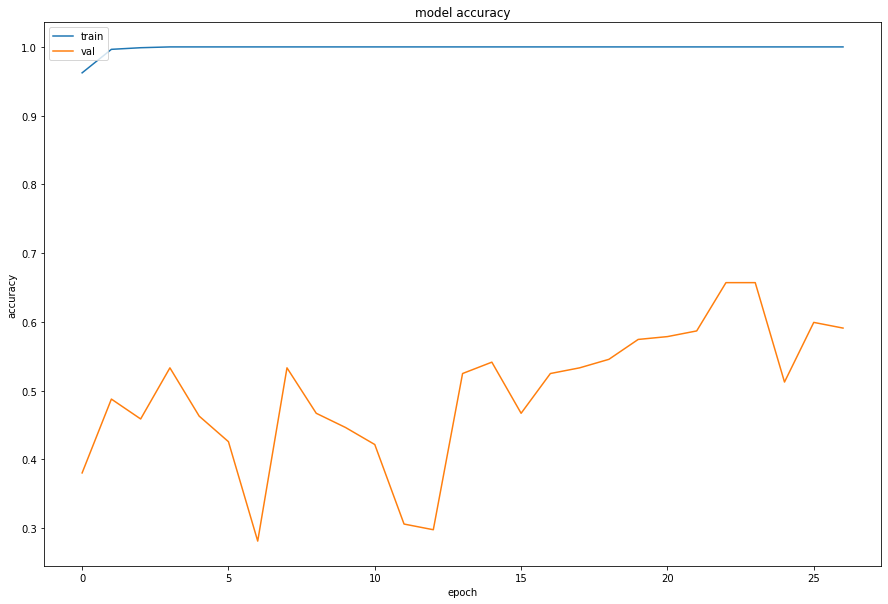

In [65]:
plt.figure(figsize=(15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

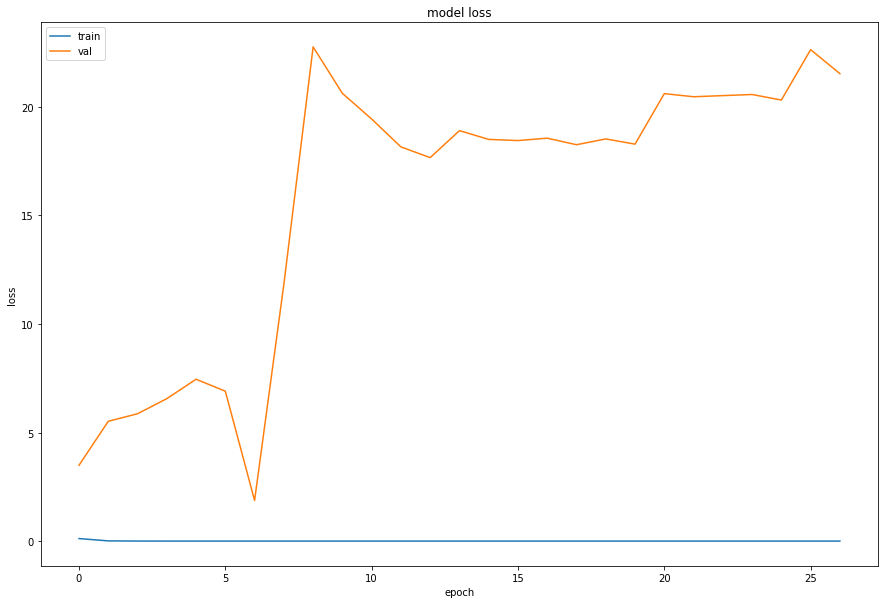

In [66]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Resnet V2 + Data Augmentation

Aggiungiamo le operazioni di data augmentation all'ImageDataGenerator di prima.

In [0]:
train_processing = kimage.ImageDataGenerator(preprocessing_function=resnet_v2.preprocess_input,
                                       # featurewise_center=True,
                                       # featurewise_std_normalization=True,
                                       # zca_whitening=True,
                                       # Rotations
                                       rotation_range=40,
                                       # # Shifts
                                       width_shift_range=0.05,
                                       height_shift_range=0.05,
                                       # # Flips
                                       # horizontal_flip=True,
                                       # vertical_flip=True,
                                       # Brightness Change
                                       # brightness_range=[0.9,1.1],
                                       # Zoom Change
                                       zoom_range=[0.9,1.1]
                                       )

In [68]:
train_generator = train_processing.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    color_mode="rgb",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=1)

Found 848 images belonging to 6 classes.


In [69]:
test_processing = kimage.ImageDataGenerator(preprocessing_function=resnet_v2.preprocess_input)

val_generator = test_processing.flow_from_directory(val_dir,
                                                    target_size=(224, 224),
                                                    color_mode="rgb",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=False,
                                                    seed=1)

test_generator = test_processing.flow_from_directory(test_dir,
                                                    target_size=(224, 224),
                                                    color_mode="rgb",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=False,
                                                    seed=1)

Found 242 images belonging to 6 classes.
Found 124 images belonging to 6 classes.


In [0]:
base_net = resnet_v2.ResNet152V2(input_shape=(224, 224, 3),
                                 weights='imagenet',
                                 include_top=False, # eliminiamo l'ultimo layer, non ci interessa.
                                 pooling='avg')

In [0]:
for layer in base_net.layers:
  layer.trainable = False # congeliamo i layer della rete resnet_v2 di base, vogliamo solo cambiare i pesi dei layer che aggiungeremo

In [0]:
x = base_net.output
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
pred = Dense(n_classes, activation='softmax')(x)
net = Model(inputs=base_net.input, outputs=pred)

In [0]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=["accuracy"])


In [0]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)

In [76]:
history = net.fit_generator(train_generator,
                  verbose=1,
                  epochs=100,
                  callbacks=[callback],
                  validation_data=val_generator)

Epoch 1/100
27/27 [==============================] - 42s 2s/step - loss: 0.1589 - accuracy: 0.9587 - val_loss: 10.0473 - val_accuracy: 0.6860
Epoch 2/100
27/27 [==============================] - 25s 926ms/step - loss: 0.0383 - accuracy: 0.9941 - val_loss: 2.0626 - val_accuracy: 0.6983
Epoch 3/100
27/27 [==============================] - 25s 926ms/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 5.5550 - val_accuracy: 0.7851
Epoch 4/100
27/27 [==============================] - 25s 927ms/step - loss: 0.0127 - accuracy: 0.9965 - val_loss: 3.8980 - val_accuracy: 0.6694
Epoch 5/100
27/27 [==============================] - 25s 926ms/step - loss: 0.0067 - accuracy: 0.9976 - val_loss: 0.0117 - val_accuracy: 0.9917
Epoch 6/100
27/27 [==============================] - 25s 926ms/step - loss: 0.0196 - accuracy: 0.9941 - val_loss: 0.1458 - val_accuracy: 0.9174
Epoch 7/100
27/27 [==============================] - 25s 928ms/step - loss: 0.0027 - accuracy: 0.9988 - val_loss: 0.7579 - val_accuracy: 0

## Evaluation


In [77]:
net.evaluate_generator(train_generator)

[0.6385504007339478, 0.6816037893295288]

In [78]:
net.evaluate_generator(val_generator)

[2.6490931759326486e-07, 0.7148760557174683]

In [79]:
net.evaluate_generator(test_generator)

[0.0009516101563349366, 0.6854838728904724]

In [80]:
cm_val, cr_val = classification_report_generator(val_generator)
print(cr_val)

              precision    recall  f1-score   support

      alinda       1.00      0.25      0.40        36
        cami       1.00      1.00      1.00        41
        gian       1.00      0.02      0.05        43
       mamma       0.87      1.00      0.93        41
        papi       1.00      1.00      1.00        41
        umbe       0.39      1.00      0.56        40

    accuracy                           0.71       242
   macro avg       0.88      0.71      0.66       242
weighted avg       0.88      0.71      0.66       242



In [81]:
cm_test, cr_test = classification_report_generator(test_generator)
print(cr_test)

              precision    recall  f1-score   support

      alinda       1.00      0.06      0.11        18
        cami       1.00      1.00      1.00        21
        gian       0.00      0.00      0.00        22
       mamma       1.00      1.00      1.00        21
        papi       1.00      1.00      1.00        21
        umbe       0.35      1.00      0.52        21

    accuracy                           0.69       124
   macro avg       0.72      0.68      0.60       124
weighted avg       0.71      0.69      0.61       124



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


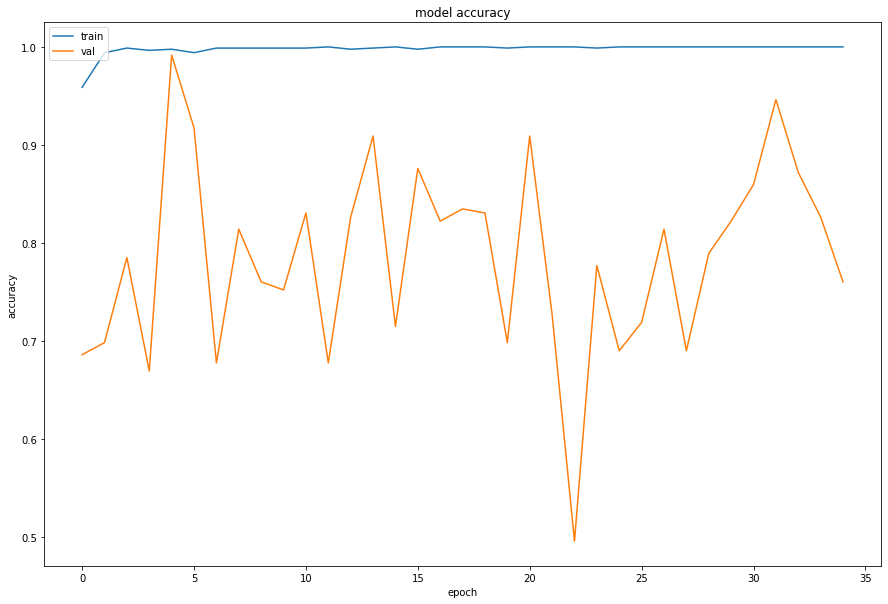

In [82]:
plt.figure(figsize=(15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

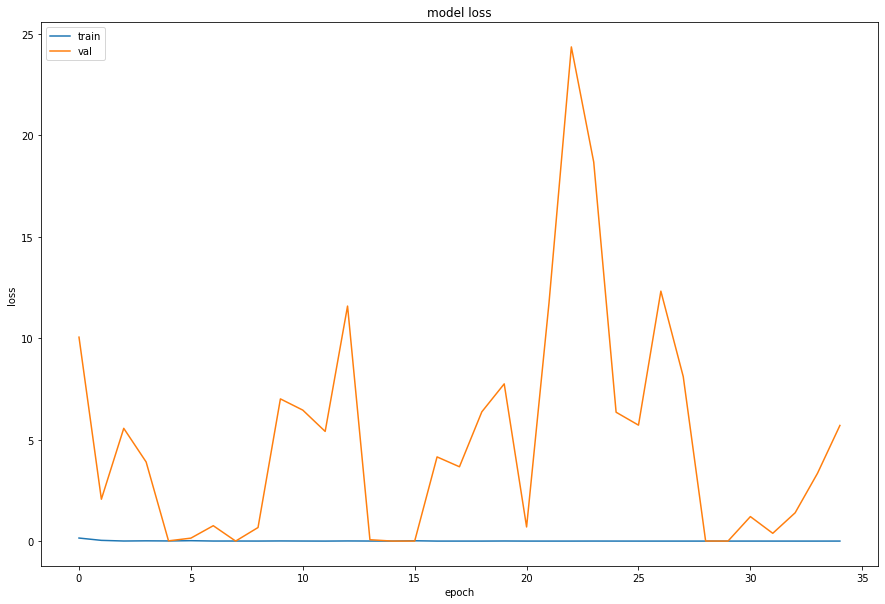

In [83]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
net.save("/content/drive/My Drive/2D/models/1_model.h5")

# TODO

- Collect more data
- Choose a better model
- look at these: 
  - https://github.com/Golbstein/keras-face-recognition
  - https://github.com/krasserm/face-recognition